In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import feature_selection_helpers as fsh
import NSCH_helpers as nh
import model_selection_helpers as mh
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, fowlkes_mallows_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
#Read in data
df = pd.read_sas('data/nsch_2019e_topical.sas7bdat')

#Clean data
df_clean = nh.clean_NSCH(df, response = 'K7Q02R_R',
               dropna_response = True,
               drop_notenrolled = True, 
               remove_sparse = False, 
               remove_unexpected = False,
               replace_with = 0,               
               state = 'both')

#manually drop features we agreed to drop until we remove them from the CSV file
df_clean_drop = df_clean.drop(columns=['a1_mental_health', 'a1_physical_health', 'a2_mental_health', 'a2_physical_health', 'costs_issue', 'is_native', 'is_asian', 'is_hispanic',
                             'is_hawaiian', 'birth_year'])

In [3]:
## Note: this cell might take 2-3 minutes to run

#Split data into features and target
X = df_clean_drop.drop(columns=['days_missed']).select_dtypes(include=['number'])
y = df_clean_drop['days_missed']

#Convert days_missed into a categorical variable: 0 means 0-6 days missed, 1 means 7+ days missed
y = y.mask(y<=3,0).mask(y>3,1)

#train test split and impute missing data. This will take ~3 minutes if imputer='rf'.
X_train, X_test, y_train, y_test = mh.split_impute(X, y, test_size=0.2, imputer = 'rf',has_response = False,test_has_response = False)

#remove the state feature (the only non-numerical feature). Store it in X_train_states and X_test_states in case we need it later
X_train_states = X_train.pop('ABBR')
X_test_states = X_test.pop('ABBR')

In [4]:
#Scale all features (not necessary for random forest; might help logistic regression)
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)

array([[-0.81946134,  0.33016151, -0.17030477, ..., -0.39860661,
         0.32378395,  0.88327102],
       [ 1.78249155,  0.33016151, -0.17030477, ..., -1.41910291,
        -3.08847917, -0.61178768],
       [ 0.48151511,  0.33016151, -0.17030477, ..., -1.41910291,
         0.32378395, -1.34288781],
       ...,
       [-0.81946134,  0.33016151, -0.17030477, ...,  0.62188969,
         0.32378395,  0.88327102],
       [-0.81946134,  0.33016151, -0.17030477, ...,  0.62188969,
         0.32378395, -1.36753164],
       [ 0.48151511,  0.33016151, -0.17030477, ..., -1.41910291,
         0.32378395, -0.81715289]])

In [5]:
#Hyperparamater C=0.5 chosen using GridSearchCV() (not shown here)
lr = LogisticRegression(max_iter=10000, C=0.5)
lr.fit(X_train, y_train)
#lr = gs_lr.best_estimator_
y_train_probs = lr.predict_proba(X_train)
y_test_probs = lr.predict_proba(X_test)

In [6]:
#Train two dummy classifiers for the sake of a baseline comparison

#dmy_const predicts every data point is of the most frequent target variable category (category 0, in this case)
dmy_const = DummyClassifier(strategy='most_frequent')
dmy_const.fit(X_train, y_train)
y_train_probs = dmy_const.predict_proba(X_train)
y_test_probs = dmy_const.predict_proba(X_test)

#dmy_prob predicts that each datap point is of type 0 with probability equal to the proportion of type 0 data points in the training set
dmy_prob = DummyClassifier(strategy='stratified')
dmy_prob.fit(X_train, y_train)
y_train_probs = dmy_const.predict_proba(X_train)
y_test_probs = dmy_const.predict_proba(X_test)

In [7]:
# The hyperparameters for SVC below were chosen using a GridSearchCV (not shown here)
svc = SVC(C=1e-03, gamma=0.01, probability=True)
svc.fit(X_train, y_train)

SVC(C=1e-05, gamma=0.0001)

In [8]:
#The hyperparameter in KNN below was chosen by increasing n_neighbors until the model stopped overfitting the training set
knn =  KNeighborsClassifier(n_neighbors=16)
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=16)

In [9]:
#The hyperparameters in the RandonForestClassifier() below were chosen using a GridSearchCV() (not shown here)
rf = RandomForestClassifier(n_estimators=100,max_depth=5)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)

In [10]:
clfs = [('Most_frequent dummy', dmy_const), ('Stratified dummy', dmy_prob), ('Logisitic regression', lr), ('SVC', svc), ('KNN', knn), ('rf', rf)]

#Excluding SVC and KNN because they do not provide interpretable model weights and excluding SVC_const because it does not have well-defined precision
#clfs = [('Stratified dummy', dmy_prob), ('Logisitic regression', lr), ('Random forest', rf)]

Stratified dummy model performance on the training data:


,Threshold = 0.1,Threshold = 0.2,Threshold = 0.5,Threshold = 0.0
Accuracy,0.790517,0.790517,0.790517,0.790517
Precision,0.120673,0.120673,0.120673,0.120673
Recall,0.123607,0.123607,0.123607,0.123607
Average_Precision_Score,0.118224,0.118224,0.118224,0.118224
F1 score,0.122122,0.122122,0.122122,0.122122


Stratified dummy model performance on the test data:


,Threshold = 0.1,Threshold = 0.2,Threshold = 0.5,Threshold = 0.0,Threshold = 0.0
Accuracy,0.794602,0.794602,0.794602,0.794602,0.794602
Precision,0.107438,0.107438,0.107438,0.107438,0.107438
Recall,0.108333,0.108333,0.108333,0.108333,0.108333
Average_Precision_Score,0.113860,0.113860,0.113860,0.113860,0.113860
F1 score,0.107884,0.107884,0.107884,0.107884,0.107884


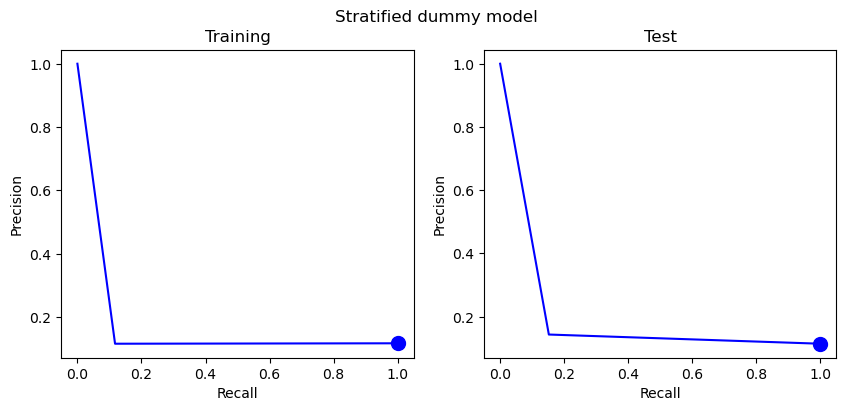

Logisitic regression model performance on the training data:


,Threshold = 0.1,Threshold = 0.2,Threshold = 0.5,Threshold = 0.159
Accuracy,0.727696,0.851248,0.894482,0.822883
Precision,0.261878,0.397053,0.662480,0.349057
Recall,0.720365,0.505066,0.213779,0.581054
Average_Precision_Score,0.448368,0.448368,0.448368,0.448368
F1 score,0.384117,0.444593,0.323248,0.436122


Logisitic regression model performance on the test data:


,Threshold = 0.1,Threshold = 0.2,Threshold = 0.5,Threshold = 0.159,Threshold = 0.203
Accuracy,0.729878,0.855027,0.895629,0.825173,0.855983
Precision,0.263273,0.400000,0.633540,0.344828,0.401914
Recall,0.754167,0.529167,0.212500,0.583333,0.525000
Average_Precision_Score,0.424241,0.424241,0.424241,0.424241,0.424241
F1 score,0.390296,0.455605,0.318253,0.433437,0.455285


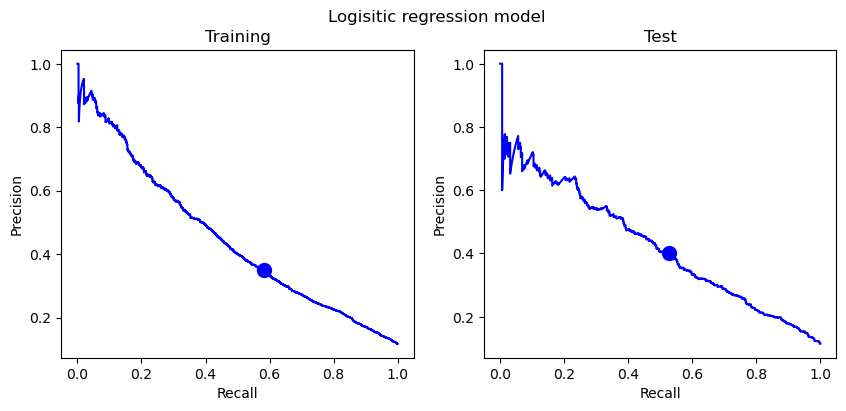

Random forest model performance on the training data:


,Threshold = 0.1,Threshold = 0.2,Threshold = 0.5,Threshold = 0.215
Accuracy,0.682312,0.857518,0.891556,0.868446
Precision,0.239489,0.411891,0.903061,0.443679
Recall,0.779129,0.487842,0.089666,0.456940
Average_Precision_Score,0.464039,0.464039,0.464039,0.464039
F1 score,0.366365,0.446660,0.163134,0.450212


Random forest model performance on the test data:


,Threshold = 0.1,Threshold = 0.2,Threshold = 0.5,Threshold = 0.215,Threshold = 0.151
Accuracy,0.683783,0.861237,0.890614,0.869119,0.811560
Precision,0.232234,0.412174,0.775000,0.431174,0.329282
Recall,0.762500,0.493750,0.064583,0.443750,0.620833
Average_Precision_Score,0.426282,0.426282,0.426282,0.426282,0.426282
F1 score,0.356031,0.449289,0.119231,0.437372,0.430325


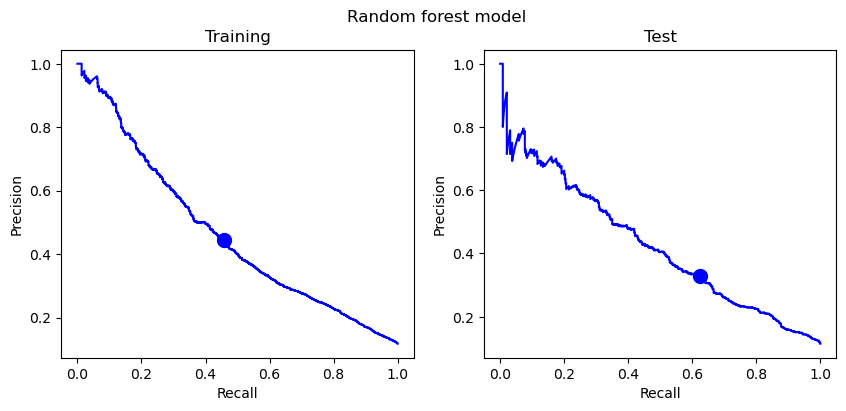

In [11]:
## For each classifier in clfs, calculate accuracy, precision, recall, 
## average precision score (i.e., area under the precisio-recall curve), 
## and f1 score (harmonic mean of precision and recall) on the training and test data

for name, clf in clfs:    
    y_train_probs = clf.predict_proba(X_train)
    y_test_probs = clf.predict_proba(X_test)

    #Display model results on the training data
    prec_train, rec_train, thresh_train = precision_recall_curve(y_train, y_train_probs[:,1])

    print(name + ' model performance on the training data:')

    opt_prec_train, opt_rec_train , opt_thresh_train, _ = mh.optimal_threshold(prec_train, rec_train, thresh_train)
    display(mh.clf_metrics(clf,X_train,y_train,threshold=[0.1, 0.2, 0.5, opt_thresh_train]))

    #Display model results on the test data
    prec_test, rec_test, thresh_test = precision_recall_curve(y_test, y_test_probs[:,1])

    print(name + ' model performance on the test data:')

    opt_prec_test, opt_rec_test , opt_thresh_test, _ = mh.optimal_threshold(prec_test, rec_test, thresh_test)
    display(mh.clf_metrics(clf,X_test,y_test,threshold=[0.1, 0.2, 0.5, opt_thresh_train, opt_thresh_test]))

    #plot precision-recall curves from the classifiers on the training and test data
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10,4)
    fig.suptitle(name + ' model')
    ax1.plot(rec_train, prec_train, 'b')
    ax1.plot(opt_rec_train, opt_prec_train, 'ob', markersize=10)
    ax1.set_title('Training')
    ax1.set_ylabel('Precision')
    ax1.set_xlabel('Recall')
    ax2.plot(rec_test, prec_test, 'b')
    ax2.plot(opt_rec_test, opt_prec_test, 'ob', markersize=10)
    ax2.set_title('Test')
    ax2.set_ylabel('Precision')
    ax2.set_xlabel('Recall')
    plt.show()

From the above, it seems logistic regression and random forest perform similarly and both outperform the dummy classifier. I suggest we use logistic regression since it's the more interpretable model of the two.